In [1]:
import sys
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import os
import matplotlib
import matplotlib.pyplot as plt 
import random
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics 
import tensorflow.contrib.rnn as rnn 
from sklearn.utils import shuffle


In [2]:
PATH = 'DATASET/'
TRAIN = 'traj_1_train_shuffled.csv'
TEST = 'traj_1_test_shuffled.csv'

In [3]:
print('Reading CSV Data...')
df = pd.read_csv(PATH + TRAIN)
test_df = pd.read_csv(PATH + TEST)

#Create a new feature for normal (non-fraudulent) transactions.
df.loc[df.label == 0, 'Slip'] = 1
df.loc[df.label == 1, 'Slip'] = 0

test_df.loc[test_df.label == 0, 'Slip'] = 1
test_df.loc[test_df.label == 1, 'Slip'] = 0

#Rename 'Class' to 'Fraud'.
df = df.rename(columns={'label': 'Stable'})
test_df = test_df.rename(columns={'label': 'Stable'})

#Create dataframes of only Fraud and Normal transactions.
Slip = df[df.Slip == 1]
Stable = df[df.Stable == 1]

test_Slip = test_df[test_df.Slip == 1]
test_Stable = test_df[test_df.Stable == 1]

# Set X_train equal to 80% of the fraudulent transactions.
#X_train = Slip.sample
#count_Slips = len(Slip)

# Add 80% of the normal transactions to X_train.
X_train = pd.concat([Slip, Stable], axis = 0)
X_test = pd.concat([test_Slip, test_Stable], axis = 0)

# X_test contains all the transaction not in X_train.
#X_test = df.loc[~df.index.isin(X_train.index)]

#Shuffle the dataframes so that the training is done in a random order.
X_train = shuffle(X_train)
X_test = shuffle(test_df)

#Add our target features to y_train and y_test.
y_train = X_train.Slip
y_train = pd.concat([y_train, X_train.Stable], axis=1)

y_test = X_test.Slip
y_test = pd.concat([y_test, X_test.Stable], axis=1)

#Drop target features from X_train and X_test.
X_train = X_train.drop(['Slip','Stable'], axis = 1)
X_test = X_test.drop(['Slip','Stable'], axis = 1)


#Select certain features
#cols = [c for c in X_train.columns if c.lower()[:5] != 'median']
X_train = X_train[X_train.columns.drop(list(X_train.filter(regex='left')))]
X_test = X_test[X_test.columns.drop(list(X_test.filter(regex='left')))]

#X_train = X_train[X_train.columns.drop(list(X_train.filter(regex='right')))]
#X_test = X_test[X_test.columns.drop(list(X_test.filter(regex='right')))]

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


#X_train = X_train[:, 3]
#y_train = y_train[:, 1]

#X_test = X_test[:, 3]
#y_test = y_test [:, 1]
print (X_test.shape)
#print (y_train.shape)


Reading CSV Data...
(35, 85)


In [4]:
learning_rate = 0.02
training_epochs = 10000
batch_size = 128
display_step = 2

# Network Parameters
num_input = X_train[0, :].size
print (num_input)
timesteps = 1
num_hidden = int(X_train[0, :].size * .5)
num_classes = 2 

85


In [5]:
# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [6]:
#tf.reset_default_graph()


def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    with tf.variable_scope('lstm1'):
        outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [7]:


logits = RNN(X, weights, biases)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [8]:
accuracy_summary = [] # Record accuracy values for plot
cost_summary = [] # Record cost values for plot

In [9]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    
    accuracy_summary.append([])
    cost_summary.append([])
    
    for epoch in range(1, training_epochs+1):
        
        for batch in range(int(num_input/batch_size)):
            batch_x = X_train[batch*batch_size : (1+batch)*batch_size]
            batch_y = y_train[batch*batch_size : (1+batch)*batch_size]
            
            batch_x = batch_x.reshape((batch_size, timesteps, num_input))
            #print ("Batch shape", batch_x.shape)
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            
            if epoch % display_step == 0 or epoch == 1:
                # Calculate batch loss and accuracy
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
                
                accuracy_summary[-1].append(acc)
                cost_summary[-1].append(loss)
                #print("Step " + str(epoch) + ", Minibatch Loss= " + \
                 #     "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  #    "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for test data
    test_len = 22
    test_data = X_test[:test_len].reshape((-1, timesteps, num_input))
    test_label = y_test[:test_len]
    print (accuracy_summary)
    #print("Testing Accuracy:", \
       # sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))
    
    #print (prediction.eval(feed_dict = {X: test_data, Y: test_label}))
    


Optimization Finished!
[[]]


ZeroDivisionError: integer division or modulo by zero

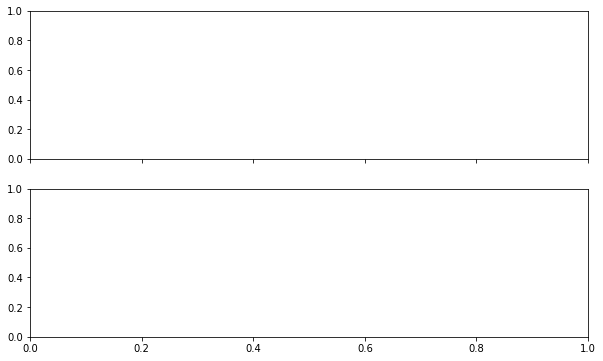

In [10]:
#fig = dict(data=data, layout=layout)

#py.iplot(fig, filename='Sine Wave Slider')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))
ax1.plot(accuracy_summary, color = 'blue',  label = 'training') # green
ax1.set_title('Accuracy')
ax2.plot(cost_summary, color = 'green',  label = 'training')
ax2.set_title('Cost')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.xlabel('Epochs (x10)')
plt.show()